# Alzheimer prediction using PET signals

Dataset is composed of PET signals averaged over a set of 69 ROIs (Region of Interest) from 60 subjects, half controls and half with Alzheimer’s disease. Data comes from the ADNI
database (http://adni.loni.usc.edu/) and has been pre-processed by the Clinica team using the procedure explained here: http://www.clinica.run/doc/Pipelines/PET_Volume/.

Please load the data from the file: ’Data_ADNI.npz’ where *X* is a matrix containing the averaged PET signals (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *labels* contains the name of the ROI of each feature.

In [0]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

# Libraries
import numpy as np
!pip install -q nilearn
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1ver_4zqkVZfr2pFVT3BIRcx6fEymrrPV',
dest_path='./Data_ADNI.npz')
gdd.download_file_from_google_drive(file_id='1Q1Y-lMhGEFDO9sijZGslOPqZeGuz7mS0',
dest_path='./atlas.nii')

with np.load('./Data_ADNI.npz',allow_pickle=True) as data:
    X = data['X'] # original landmarks   
    y = data['y'] # landmarks after GPA    
    labels = data['labels']    

 # Transform from characters to list of strings   
labels=labels.tolist()
for i in range(0,len(labels)):    
    labels[i]=''.join(labels[i])
    
N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))

Number of controls and Alzheimer patients is respectively: 30 and 30


Using the library nilearn we can also plot the atlas used to define the ROIs:

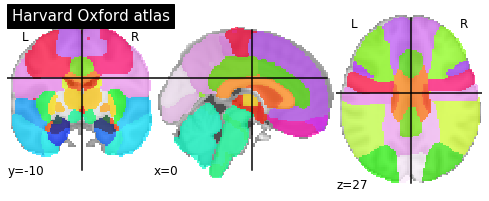

In [0]:
plotting.plot_roi('./atlas.nii', title="Harvard Oxford atlas")
plotting.show()

In this session we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to scale the features so that each feature will have average equal to 0 and unit variance and create a training and test set.

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Scale data (each feature will have average equal to 0 and unit variance)
Xmean = np.mean(X,axis=0) # Compute average
Xstd=np.std(X,axis=0)    # Compute standard deviation
X_scale=(X-Xmean)/Xstd

# Create training and test set
X_train, X_test, y_train, y_test =train_test_split(X_scale, y, test_size=0.25, random_state=42)

Then, we can fit a Decision tree, with the default setting, using the following code:

In [0]:
from sklearn.tree import DecisionTreeClassifier

# Fitting Decision Trees
Tree = DecisionTreeClassifier()
Tree.fit(X_train,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )
# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 1.0
Score in the test set is 0.8


We can also use the *graphviz* library to plot the decision tree. Please install it using *conda install python-graphviz*. 
 

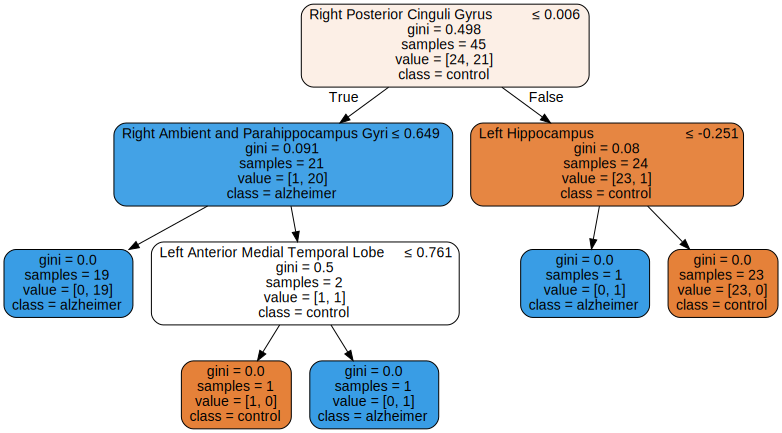

In [0]:
from sklearn import tree
import graphviz 

dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Other than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 

First, divide the data into training and test set and then plot the training and test test score for different values of 'min_samples_split' and 'min_samples_leaf'. What is the best value ? What happens if you split differently your data ?

In [0]:
from sklearn.model_selection import GridSearchCV, KFold
#try different hyperparameters
p_grid_Tree = {'min_samples_split': [2,3,4,5,6],
              'min_samples_leaf': [1,2,3,4,5], }
grid_Tree = GridSearchCV(estimator=Tree, param_grid=p_grid_Tree, scoring="accuracy", cv=4)
grid_Tree.fit(X_scale,y)
print("Best Score: {}".format(grid_Tree.best_score_))
print("Best params: {}".format(grid_Tree.best_params_))

#split data differently
print('split data differently') 
grid_Tree = GridSearchCV(estimator=Tree, param_grid=p_grid_Tree, scoring="accuracy", cv=2)
grid_Tree.fit(X_scale,y)
print("Best Score: {}".format(grid_Tree.best_score_))
print("Best params: {}".format(grid_Tree.best_params_))

Best Score: 0.9
Best params: {'min_samples_leaf': 5, 'min_samples_split': 5}
split data differently
Best Score: 0.8833333333333333
Best params: {'min_samples_leaf': 3, 'min_samples_split': 2}


Try to add Gaussian noise to the data (using for instance zero mean and 1 or 2 for the std) and, using the best hyperparameters found before, look at the test score. Repeat this process several times and compare the results with the score obtained without adding noise. Are the results stable ? Hint: you could use for instance *noise = np.random.normal(mu, sigma)*

Answer:The result is stable.

In [0]:
noise = np.random.randn(X_train.shape[0],X_train.shape[1]) 	#make sure the size of noise the same as data
noise = noise-np.mean(noise) 	#generate noise with zero mean
data_noise=X_train+noise
Tree_o = DecisionTreeClassifier(min_samples_leaf=5,min_samples_split=2)
Tree_o.fit(data_noise,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )
# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 1.0
Score in the test set is 0.8


Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values in an automatic way. Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV

In [0]:
from sklearn.model_selection import GridSearchCV

grid_Tree = GridSearchCV(estimator=Tree, param_grid=p_grid_Tree, scoring="accuracy", cv=4)
grid_Tree.fit(X_norm,y)
print("Best Score: {}".format(grid_Tree.best_score_))
print("Best params: {}".format(grid_Tree.best_params_))

Best Score: 0.9166666666666666
Best params: {'min_samples_leaf': 5, 'min_samples_split': 5}


Using the optimal hyperparameers, plot again the decision tree using the *graphviz* library. Is it the same ? Or similar ?   Answer:similar

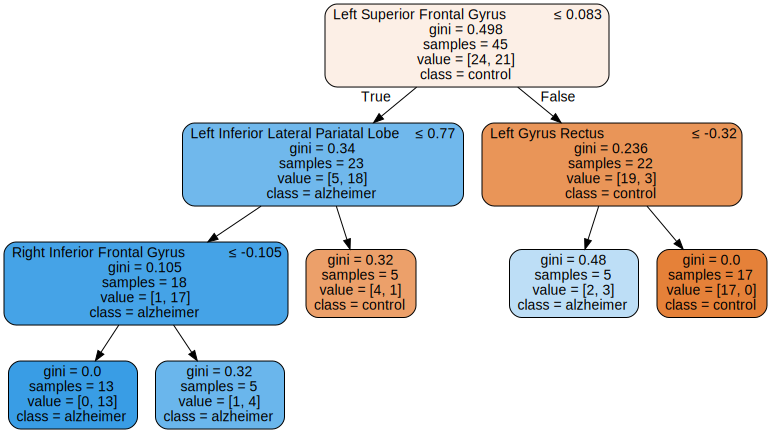

In [0]:
dot_data = tree.export_graphviz(Tree_o, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'. What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees ? 

Answer:performance is very when using noisy data

In [0]:
from sklearn.ensemble import BaggingClassifier

X_train, X_test, y_train, y_test = train_test_split(X_scale, np.ravel(y), test_size=0.25, random_state=0)
Tree = DecisionTreeClassifier(criterion="gini",min_samples_leaf=5,min_samples_split=5, random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, scoring="accuracy", cv=5)
grid_bagging.fit(X_train, y_train)
print("Best Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging score :",grid_bagging.score(X_test,y_test))

#use noisy data
grid_bagging.fit(data_noise, y_train)
print("Best Score with noisy data: {}".format(grid_bagging.best_score_))
print("Best params with noisy data: {}".format(grid_bagging.best_params_))
print("Bagging score with noisy data:",grid_bagging.score(X_test,y_test))

Best Score: 0.8666666666666667
Best params: {'n_estimators': 15}
Bagging score : 0.9333333333333333
Best Score with noisy data: 0.5555555555555556
Best params with noisy data: {'n_estimators': 5}
Bagging score with noisy data: 0.13333333333333333


The last part of this TP is about Random Forests. We can estimate the three hyperparameters *'n_estimators'*, *'min_samples_leaf'* and *'max_features'*, the number of features to consider when looking for the best split, as before using Cross Validation

In [0]:
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(criterion="gini", random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train, y_train)
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

Best Score: 0.8444444444444444
Best params: {'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 10}


We can also use Random Forests to check the importance of the features

Feature ranking:
1. feature 28 representing Right Posterior Cinguli Gyrus          (0.163334)
2. feature 1 representing Left Hippocampus                       (0.142756)
3. feature 15 representing Left Fusiform Gyrus                    (0.072881)
4. feature 3 representing Left Amygdala                          (0.069986)
5. feature 35 representing Left Caudate Nucleus                   (0.055860)
6. feature 37 representing Left Accumbens Nucleus                 (0.055629)
7. feature 14 representing Right Inferior Middle Temporal Gyri    (0.055293)
8. feature 59 representing Left Superior Frontal Gyrus            (0.044043)
9. feature 31 representing Left Posterior Temporal Lobe           (0.037708)
10. feature 2 representing Right Hippocampus                      (0.037471)


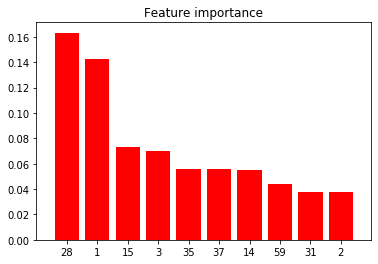

In [0]:
import matplotlib.pyplot as plt
best_params=grid_RF.best_params_
RF = RandomForestClassifier(criterion="gini",min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

Which are the most important features (i.e. ROIs) ?  Ask your clinical colleagues (or look it up on internet) if they could be right.  
Answer:Right Posterior Cinguli Gyrus

We can also inspect the data using only pairs of the most important features

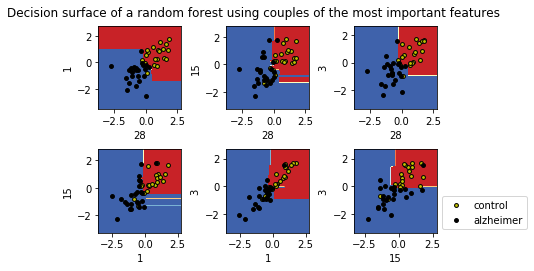

In [0]:
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "yk"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

Which is the best couple of features ?

Answer: feature 28 representing Right Posterior Cinguli Gyrus&feature 15 representing Left Fusiform Gyrus